In [2]:
import gym
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [3]:
env = gym.make('CartPole-v0').unwrapped

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [4]:
plt.ion()

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
Transition = namedtuple('Transition',
                                           ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.posision]  = Transition(*args)
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [9]:
class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.head = nn.Linear(448, 2)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

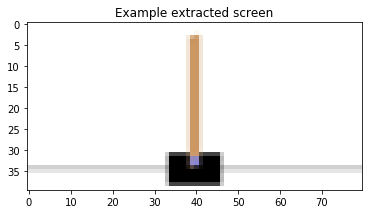

In [10]:
resize = T.Compose([T.ToPILImage(),
                                     T.Resize(40, interpolation=Image.CUBIC),
                                     T.ToTensor()])
screen_width = 600


def get_cart_location():
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART


def get_screen():
    screen = env.render(mode='rgb_array').transpose(
        (2, 0, 1))  # transpose into torch order (CHW)
    # Strip off the top and bottom of the screen
    screen = screen[:, 160:320]
    view_width = 320
    cart_location = get_cart_location()
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescare, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

    

In [11]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

In [13]:
policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

DQN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (head): Linear(in_features=448, out_features=2, bias=True)
)

In [16]:
optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

In [61]:
steps_done = 0

def select_action(state):
    global steps_done
    sample = random.sample()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).argmax(dim=1, keepdim=True)
    else:
        return torch.tensor([[random.randrange(2)]], device=device, dtype=torch.long)

In [62]:
episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [66]:
def optimzie_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions  = memory.sample(BATCH_SIZE)
    batch  = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),
                                                           device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)
    
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [68]:
help(torch.clamp)

Help on built-in function clamp:

clamp(...)
    clamp(input, min, max, out=None) -> Tensor
    
    Clamp all elements in :attr:`input` into the range `[` :attr:`min`, :attr:`max` `]` and return
    a resulting tensor:
    
    .. math::
        y_i = \begin{cases}
            \text{min} & \text{if } x_i < \text{min} \\
            x_i & \text{if } \text{min} \leq x_i \leq \text{max} \\
            \text{max} & \text{if } x_i > \text{max}
        \end{cases}
    
    If :attr:`input` is of type `FloatTensor` or `DoubleTensor`, args :attr:`min`
    and :attr:`max` must be real numbers, otherwise they should be integers.
    
    Args:
        input (Tensor): the input tensor
        min (Number): lower-bound of the range to be clamped to
        max (Number): upper-bound of the range to be clamped to
        out (Tensor, optional): the output tensor
    
    Example::
    
        >>> a = torch.randn(4)
        >>> a
        tensor([-1.7120,  0.1734, -0.0478, -0.0922])
        >>> torc

In [51]:
help(torch.Tensor.max)

Help on method_descriptor:

max(...)
    max(dim=None, keepdim=False) -> Tensor or (Tensor, Tensor)
    
    See :func:`torch.max`



In [52]:
help(torch.max)

Help on built-in function max:

max(...)
    .. function:: max(input) -> Tensor
    
    Returns the maximum value of all elements in the :attr:`input` tensor.
    
    Args:
        input (Tensor): the input tensor
    
    Example::
    
        >>> a = torch.randn(1, 3)
        >>> a
        tensor([[ 0.6763,  0.7445, -2.2369]])
        >>> torch.max(a)
        tensor(0.7445)
    
    .. function:: max(input, dim, keepdim=False, out=None) -> (Tensor, LongTensor)
    
    Returns the maximum value of each row of the :attr:`input` tensor in the given
    dimension :attr:`dim`. The second return value is the index location of each
    maximum value found (argmax).
    
    If :attr:`keepdim` is ``True``, the output tensors are of the same size
    as :attr:`input` except in the dimension :attr:`dim` where they are of size 1.
    Otherwise, :attr:`dim` is squeezed (see :func:`torch.squeeze`), resulting
    in the output tensors having 1 fewer dimension than :attr:`input`.
    
    Args:

In [53]:
a = torch.randn(4, 4)

In [60]:
a.argmax(dim=1, keepdim=True)

tensor([[ 1],
        [ 0],
        [ 3],
        [ 0]])